In [12]:
import os
import torch
import json
from io import BytesIO
import numpy as np
import torch.nn as nn
import imageio.v2 as imageio
from tqdm import tqdm, trange
from utils import PointDataset, get_xyz
from dynamic_model import PointNetModel
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cpu')

In [3]:
data_path = '/Users/reza/Career/DMLab/SURROGATE/Data/psi_web_sample'
result_path = '/Users/reza/Career/DMLab/SURROGATE/results/laplace/pointnet-sequential-slices/exp_7'
cfg_path = os.path.join(result_path, 'cfg.json')
with open(cfg_path, 'r') as f:
    cfg = json.load(f)

In [4]:
len(cfg['train_files'])

680

In [5]:
instruments = [
        "kpo_mas_mas_std_0101",
        "mdi_mas_mas_std_0101",
        "hmi_mast_mas_std_0101",
        "hmi_mast_mas_std_0201",
        "hmi_masp_mas_std_0201",
        "mdi_mas_mas_std_0201",
    ]
subdir_paths = sorted(os.listdir(data_path))
cr_paths = [os.path.join(data_path, p) for p in subdir_paths if p.startswith("cr")]
sim_paths = []
for cr_path in cr_paths:
    for instrument in instruments:
        instrument_path = os.path.join(cr_path, instrument)
        if os.path.exists(instrument_path):
            sim_paths.append(instrument_path)

In [8]:
dataset = PointDataset(sim_paths, b_min=cfg['train_min'], b_max=cfg['train_max'])

In [9]:
cfg['train_min'], cfg['train_max']

(-2.6867804527282715, 2.7947838306427)

In [10]:
model = PointNetModel(dims=cfg['dims'])
state = torch.load(os.path.join(result_path, '5.pth'), map_location=device)
model.load_state_dict(state)

/var/folders/bv/7h0f0hns2y72yqgg3ww8qkkm0000gn/T/ipykernel_1583/141716675.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(os.path.join(result_path, '5

<All keys matched successfully>

In [19]:
i = 0
cube = dataset[i]
cube = cube.unsqueeze(0)

with torch.no_grad():
    K = 9  # cube.shape[1]
    yhats = []
    x = cube[:, 0, :, :]
    for k in range(K - 1):
        yhat = model(x.to(device))
        yhats.append(yhat)
        xx, yy, zz = get_xyz(dataset.ii, dataset.jj, dataset.kk[k])
        xx, yy, zz = (
            np.tile(xx, (cube.shape[0], 1)),
            np.tile(yy, (cube.shape[0], 1)),
            np.tile(zz, (cube.shape[0], 1)),
        )
        xx, yy, zz = (
            torch.tensor(xx, dtype=torch.float32).to(device),
            torch.tensor(yy, dtype=torch.float32).to(device),
            torch.tensor(zz, dtype=torch.float32).to(device),
        )
        x = torch.stack((xx, yy, zz, yhat.squeeze().unsqueeze(0)), dim=1)
    yhats = torch.stack(yhats, dim=1)

In [20]:
cube.shape, yhats.shape

(torch.Size([1, 141, 4, 14080]), torch.Size([1, 8, 14080, 1]))

In [25]:
frames = []
for i in range(K-1):
    y = cube[:, i+1, 3, :]
    yhat = yhats[:, i, :, :]
    # print(cube.shape)
    y = y.reshape((128, 110))
    # print(yhat.shape)
    yhat = yhat.reshape((128, 110))
    y = y.transpose(1, 0)
    yhat = yhat.transpose(1, 0)

    error = np.abs(y - yhat)
    vmin = min(y.min(), yhat.min())
    vmax = max(y.max(), yhat.max())
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    cmap = "coolwarm"

    # # Plot first subplot
    im1 = axes[0].imshow(y, cmap=cmap, vmin=vmin, vmax=vmax)
    axes[0].set_title(f"gt: br002 at {i+1}")

    # Plot second subplot
    im3 = axes[1].imshow(yhat, cmap=cmap, vmin=vmin, vmax=vmax)
    axes[1].set_title(f"pred at {i+1} ")

    cbar = fig.colorbar(im1, ax=axes, orientation="horizontal", fraction=0.1, pad=0.02)

    # Plot second subplot
    im4 = axes[2].imshow(error, cmap="gray")
    axes[2].set_title(f"|pred-gt|")

    # Create a single colorbar
    cbar = fig.colorbar(im4, ax=axes, orientation="vertical", fraction=0.05, pad=0.02)

    # plt.tight_layout()
    buf = BytesIO()
    plt.savefig(buf, format="png")
    frames.append(imageio.imread(buf))
    plt.close()

/var/folders/bv/7h0f0hns2y72yqgg3ww8qkkm0000gn/T/ipykernel_1583/440392049.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  error = np.abs(y - yhat)


In [28]:
output_filename = f"v{i}.gif"
fps = 2  # Adjust frames per second as needed

# Create video directly from frames in memory
with imageio.get_writer(output_filename, fps=fps) as writer:
    for frame in frames:
        writer.append_data(frame)

/var/folders/bv/7h0f0hns2y72yqgg3ww8qkkm0000gn/T/ipykernel_2194/37516033.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  error = np.abs(y-yhat)


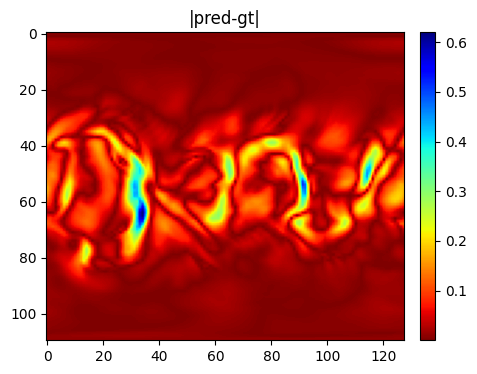

In [11]:
error = np.abs(y-yhat)

fig, axes = plt.subplots(1, 1, figsize=(10, 4))
cmap = "jet_r"

im = axes.imshow(error, cmap='jet_r')
axes.set_title('|pred-gt|')

# Create a single colorbar
fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.05, pad=0.02)

# plt.tight_layout()
plt.show()